# 03 – Exploratory Data Analysis and Data Fusion (PySpark)

This notebook performs exploratory data analysis and demonstrates different fusion strategies.  We investigate distribution of variables, relationships between features and the target, and how to combine data sources.

**Fusion strategies:**
- **Early Fusion**: Join all relevant tables into a single wide table.
- **Hybrid Fusion**: Aggregate behaviour logs into features (counts) and merge them into the click log.

We use PySpark for heavy data processing and Pandas for visualisation on sampled data.


Spark version: 4.0.1
Project root: d:\projects\Ai\project_fusion_ecu
Processed data dir: d:\projects\Ai\project_fusion_ecu\data\processed
Loaded cleaned DataFrames:
user_df rows:      1000000
ad_df rows:        846811
click_df rows:     1000000
behavior_df rows:  930695

Schemas:

Schema for User Profile:
root
 |-- userid: integer (nullable = true)
 |-- cms_segid: integer (nullable = true)
 |-- cms_group_id: integer (nullable = true)
 |-- final_gender_code: integer (nullable = true)
 |-- age_level: integer (nullable = true)
 |-- pvalue_level: integer (nullable = true)
 |-- shopping_level: integer (nullable = true)
 |-- occupation: integer (nullable = true)
 |-- new_user_class_level : integer (nullable = true)


Schema for Ad Feature:
root
 |-- adgroup_id: double (nullable = true)
 |--  cate_id: double (nullable = true)
 |--  campaign_id: double (nullable = true)
 |--  customer: double (nullable = true)
 |--  brand : string (nullable = true)
 |--  price: double (nullable = true)


Schem

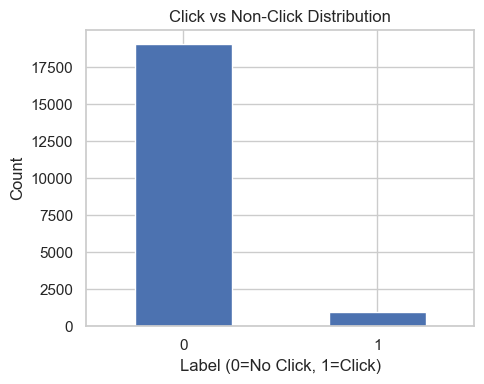

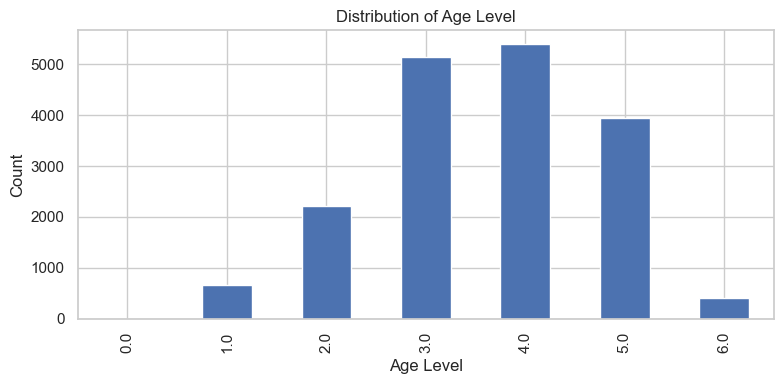

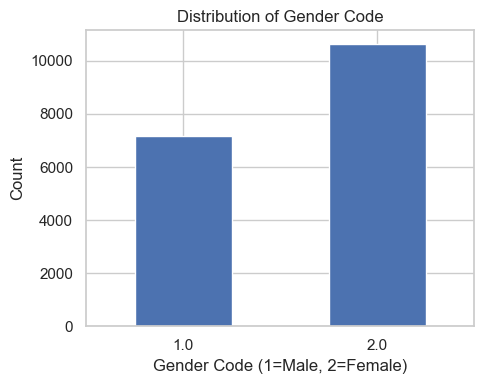

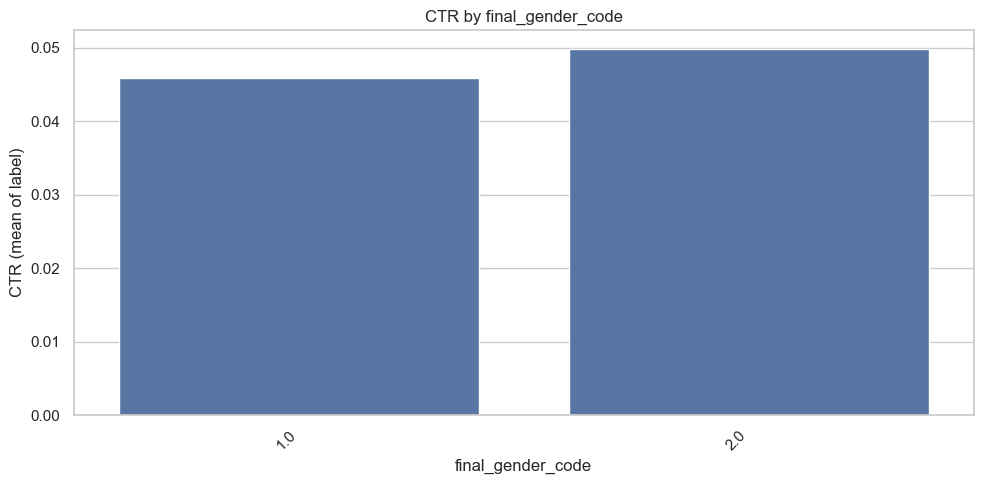

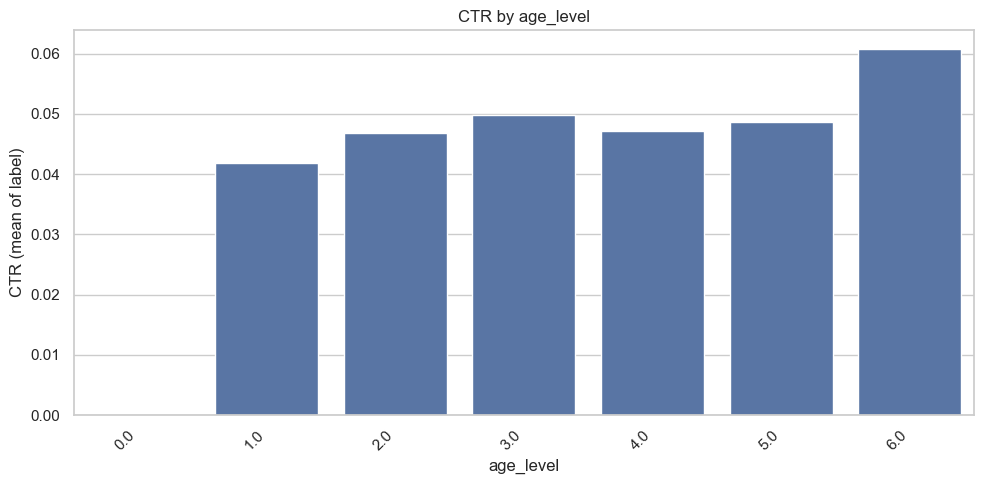


Number of numeric columns for correlation: 21


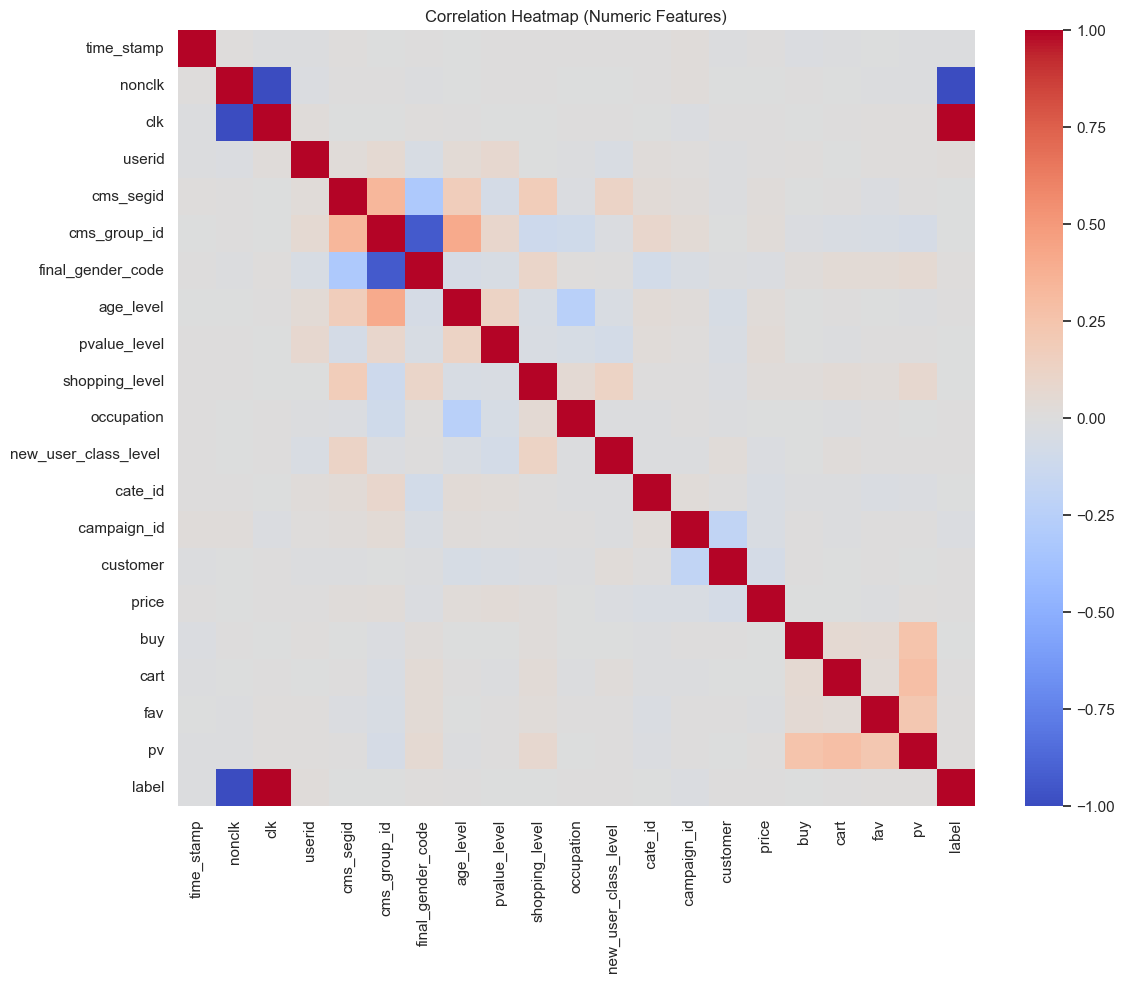

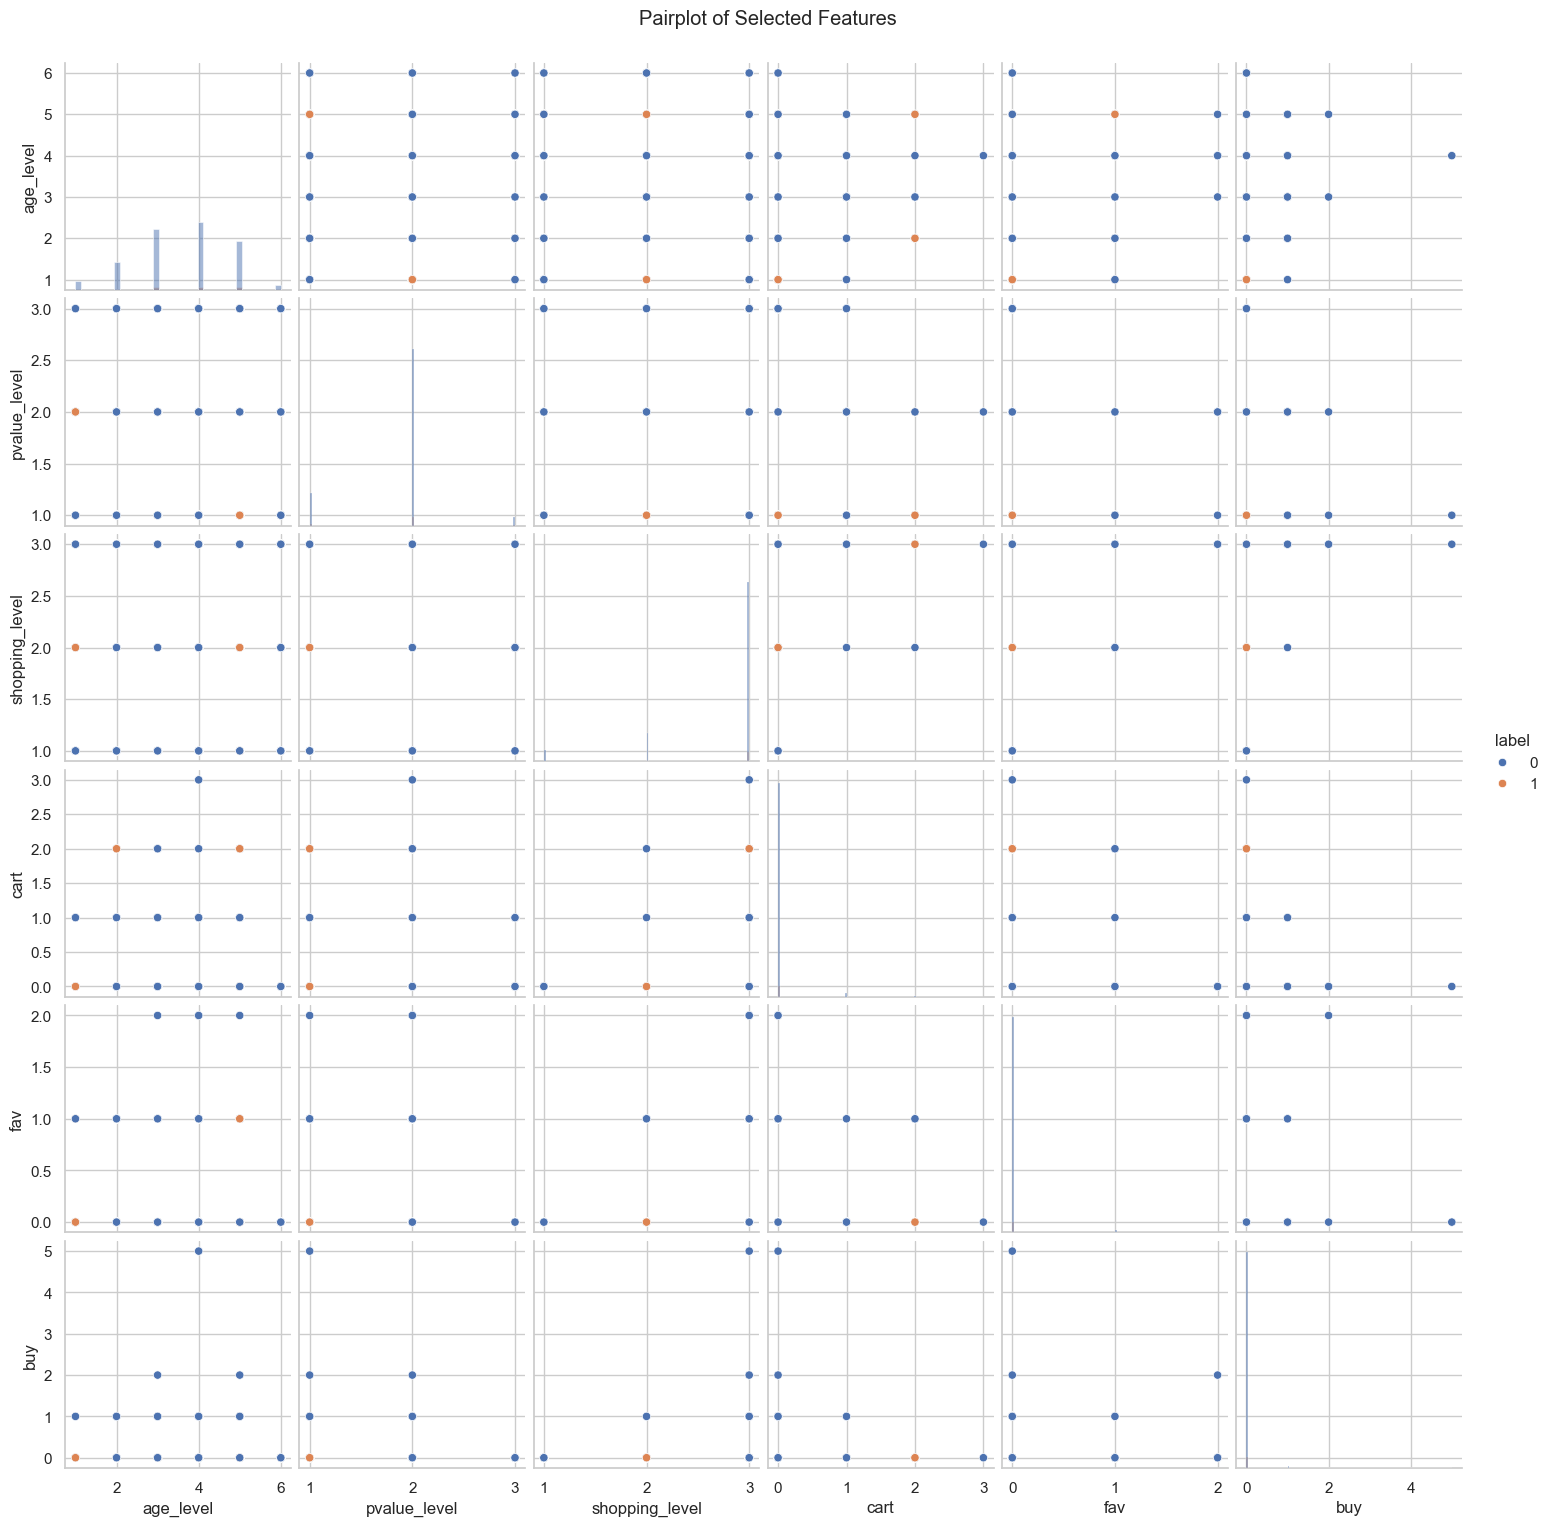


Converting full fused DataFrame to Pandas for saving (this may take a while)...
Fused Pandas DataFrame shape: (1000000, 28)
Saved fused data to: d:\projects\Ai\project_fusion_ecu\data\processed\fused_data.csv

Spark session stopped.


: 

In [ ]:
# ============================================
# 0. Imports and Spark session for EDA + Fusion
# ============================================

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import count, col
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid")

# Create Spark session for EDA and fusion work
spark = (
    SparkSession.builder
        .appName("CTR_EDA_Fusion")
        .master("local[4]")                     # good balance for your laptop
        .config("spark.sql.shuffle.partitions", "100")
        .config("spark.driver.memory", "6g")
        .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("Spark version:", spark.version)

# ============================================
# 1. Define paths and load cleaned data
# ============================================

# Assuming this notebook is in: D:/projects/Ai/project_fusion_ecu/notebooks
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
processed_dir = os.path.join(project_root, "data", "processed")

print("Project root:", project_root)
print("Processed data dir:", processed_dir)

# Load cleaned data from CSV (created in 02_data_cleaning notebook)
user_df = spark.read.csv(
    os.path.join(processed_dir, "user_profile_clean.csv"),
    header=True,
    inferSchema=True,
)

ad_df = spark.read.csv(
    os.path.join(processed_dir, "ad_feature_clean.csv"),
    header=True,
    inferSchema=True,
)

click_df = spark.read.csv(
    os.path.join(processed_dir, "raw_sample_clean.csv"),
    header=True,
    inferSchema=True,
)

behavior_df = spark.read.csv(
    os.path.join(processed_dir, "behavior_log_clean.csv"),
    header=True,
    inferSchema=True,
)

print("Loaded cleaned DataFrames:")
print("user_df rows:     ", user_df.count())
print("ad_df rows:       ", ad_df.count())
print("click_df rows:    ", click_df.count())
print("behavior_df rows: ", behavior_df.count())

# Optional: inspect schemas
print("\nSchemas:")
for name, df in [
    ("User Profile", user_df),
    ("Ad Feature", ad_df),
    ("Click Log", click_df),
    ("Behavior Log", behavior_df),
]:
    print(f"\nSchema for {name}:")
    df.printSchema()

# ============================================
# 2. Early Fusion: join click log with user and ad information
# ============================================

# Early fusion builds a wide table where:
# - each impression (row in raw_sample) is enriched with:
#   * user attributes (age, gender, value segments, ...)
#   * ad attributes (category, brand, price, ...)

# Adjust join keys as needed based on your actual column names.
# Here we assume:
#   click_df.user        == user_df.userid
#   click_df.adgroup_id  == ad_df.adgroup_id

click_user_df = click_df.join(
    user_df,
    click_df["user"] == user_df["userid"],
    how="left"
)

full_df = click_user_df.join(
    ad_df,
    click_user_df["adgroup_id"] == ad_df["adgroup_id"],
    how="left"
)

print("\nAfter early fusion (click + user + ad):")
print("Rows:", full_df.count())
print("Columns:", len(full_df.columns))

# ============================================
# 3. Hybrid Fusion: aggregate behavior log per user and join
# ============================================

# Behavior log (raw_behavior_log) contains user-level actions:
#  - btag ∈ {ipv, cart, fav, buy}
#  - cate, brand, etc.
#
# We aggregate behavior per user:
#   * number of ipv events
#   * number of cart events
#   * number of fav events
#   * number of buy events
#
# Then we join these aggregate features back to the fused table.

# If your user column is "nick" instead of "user", change "user" here.
group_key = "user"  # or "nick" if that is the ID column in behavior_df

# IMPORTANT FIX:
# Use count("btag") instead of count("*") to avoid the pivot error:
# [INVALID_USAGE_OF_STAR_OR_REGEX] Invalid usage of '*' in Pivot.

behaviour_counts = (
    behavior_df.groupBy(group_key)
    .pivot("btag")                 # columns: buy, cart, fav, ipv
    .agg(F.count("btag"))          # valid in pivot
    .fillna(0)                     # replace null with 0
)

print("\nBehavioral aggregation (per user):")
behaviour_counts.show(5)

# Join aggregated behavioral features onto the early fused table.
# If group_key is "nick", adjust the join condition accordingly.
full_df = full_df.join(
    behaviour_counts,
    full_df["user"] == behaviour_counts[group_key],
    how="left"
)

# Fill any remaining nulls in behavioral columns with 0.
for col_name in behaviour_counts.columns:
    if col_name != group_key:
        full_df = full_df.fillna({col_name: 0})

print("\nAfter hybrid fusion (added aggregated behavior features):")
print("Rows:", full_df.count())
print("Columns:", len(full_df.columns))

# ============================================
# 4. Add CTR-related fields for EDA
# ============================================

# raw_sample typically contains:
#  - clk  (1 if clicked, 0 otherwise)
#  - noclk (1 if not clicked, 0 otherwise)
#
# For EDA, it's convenient to have:
#  - label = clk (0/1)
#  - maybe total_impressions = clk + noclk

if "clk" in full_df.columns:
    full_df = full_df.withColumn("label", col("clk").cast("int"))
else:
    print("WARNING: Column 'clk' not found. Some CTR plots will be skipped.")

if "clk" in full_df.columns and "noclk" in full_df.columns:
    full_df = full_df.withColumn("impressions", (col("clk") + col("noclk")).cast("int"))

# ============================================
# 5. Sampling for EDA (to avoid memory issues)
# ============================================

# We'll use a sample of the fused data for plotting.
# This keeps EDA responsive and avoids loading full 1M rows into RAM.

SAMPLE_SIZE = 20_000

print(f"\nSampling {SAMPLE_SIZE} rows for EDA...")
sample_df = full_df.limit(SAMPLE_SIZE).toPandas()
print("Sample shape:", sample_df.shape)

# ============================================
# 6. EDA – Univariate: distributions
# ============================================

# 6.1 Distribution of price
if "price" in sample_df.columns:
    plt.figure(figsize=(8, 5))
    sample_df["price"].dropna().hist(bins=50)
    plt.title("Distribution of Item Price")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'price' not found: skipping price distribution.")

# 6.2 Distribution of label (click vs no-click)
if "label" in sample_df.columns:
    plt.figure(figsize=(5, 4))
    sample_df["label"].value_counts().sort_index().plot(
        kind="bar",
        rot=0
    )
    plt.title("Click vs Non-Click Distribution")
    plt.xlabel("Label (0=No Click, 1=Click)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'label' not found: skipping click distribution.")

# 6.3 Distribution of user age_level (if available)
if "age_level" in sample_df.columns:
    plt.figure(figsize=(8, 4))
    sample_df["age_level"].value_counts().sort_index().plot(
        kind="bar"
    )
    plt.title("Distribution of Age Level")
    plt.xlabel("Age Level")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 6.4 Distribution of final_gender_code (if available)
if "final_gender_code" in sample_df.columns:
    plt.figure(figsize=(5, 4))
    sample_df["final_gender_code"].value_counts().sort_index().plot(
        kind="bar",
        rot=0
    )
    plt.title("Distribution of Gender Code")
    plt.xlabel("Gender Code (1=Male, 2=Female)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ============================================
# 7. EDA – Bivariate: CTR by categorical features
# ============================================

# Helper: compute CTR = mean(label) for a given categorical column
def plot_ctr_by_category(pdf, cat_col, top_n=10, title_prefix="CTR by"):
    if "label" not in pdf.columns or cat_col not in pdf.columns:
        print(f"Skipping {cat_col}: missing required columns.")
        return

    # Drop rows with missing category
    tmp = pdf[[cat_col, "label"]].dropna()

    # Compute mean label = CTR per category
    ctr = (
        tmp.groupby(cat_col)["label"]
        .mean()
        .reset_index()
        .rename(columns={"label": "ctr"})
    )

    # Keep top N categories by count (for readability)
    counts = tmp[cat_col].value_counts().reset_index()
    counts.columns = [cat_col, "count"]
    ctr = ctr.merge(counts, on=cat_col)
    ctr = ctr.sort_values("count", ascending=False).head(top_n)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=ctr, x=cat_col, y="ctr")
    plt.title(f"{title_prefix} {cat_col}")
    plt.ylabel("CTR (mean of label)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# CTR by gender
if "final_gender_code" in sample_df.columns:
    plot_ctr_by_category(sample_df, "final_gender_code", top_n=3, title_prefix="CTR by")

# CTR by age level
if "age_level" in sample_df.columns:
    plot_ctr_by_category(sample_df, "age_level", top_n=10, title_prefix="CTR by")

# CTR by ad category
if "cate_id" in sample_df.columns:
    plot_ctr_by_category(sample_df, "cate_id", top_n=10, title_prefix="CTR by cate_id")

# CTR by brand
if "brand" in sample_df.columns:
    plot_ctr_by_category(sample_df, "brand", top_n=10, title_prefix="CTR by brand")

# ============================================
# 8. EDA – Boxplot: price vs click
# ============================================

if "price" in sample_df.columns and "label" in sample_df.columns:
    plt.figure(figsize=(6, 5))
    sns.boxplot(x="label", y="price", data=sample_df)
    plt.title("Price Distribution by Click Label")
    plt.xlabel("Label (0=No Click, 1=Click)")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

# ============================================
# 9. EDA – Correlation heatmap (numeric features)
# ============================================

numeric_cols = [
    c for c in sample_df.columns
    if pd.api.types.is_numeric_dtype(sample_df[c])
]

print("\nNumber of numeric columns for correlation:", len(numeric_cols))

if len(numeric_cols) > 1:
    corr = sample_df[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        annot=False,
        cmap="coolwarm",
        center=0
    )
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to plot a correlation heatmap.")

# ============================================
# 10. EDA – Pairplot for selected important features
# ============================================

# Select a small subset of numeric columns for pairplot
candidate_cols = []
for col_candidate in ["price", "age_level", "pvalue_level", "shopping_level", "ipv", "cart", "fav", "buy"]:
    if col_candidate in sample_df.columns and pd.api.types.is_numeric_dtype(sample_df[col_candidate]):
        candidate_cols.append(col_candidate)

if "label" in sample_df.columns:
    candidate_cols.append("label")

candidate_cols = list(dict.fromkeys(candidate_cols))  # remove duplicates

if len(candidate_cols) >= 3:
    sns.pairplot(
        sample_df[candidate_cols].dropna().sample(min(3000, len(sample_df))),
        hue="label" if "label" in candidate_cols else None,
        diag_kind="hist"
    )
    plt.suptitle("Pairplot of Selected Features", y=1.02)
    plt.show()
else:
    print("Not enough columns for a meaningful pairplot.")

# ============================================
# 11. Save fused data for later modeling
# ============================================

# For modeling, we want the full fused table (not just the sample).
# To avoid Spark/Hadoop issues on Windows, we convert to Pandas and save as CSV.

print("\nConverting full fused DataFrame to Pandas for saving (this may take a while)...")
fused_pdf = full_df.toPandas()
print("Fused Pandas DataFrame shape:", fused_pdf.shape)

fused_csv_path = os.path.join(processed_dir, "fused_data.csv")
fused_pdf.to_csv(fused_csv_path, index=False)

print("Saved fused data to:", fused_csv_path)

# ============================================
# 12. Stop Spark session
# ============================================

spark.stop()
print("\nSpark session stopped.")
